##

### Info

-  Notebook is about data correction: analysing, visualising and correcting data of all forms.

Table of content:
- Cleaning.
- Correcting data.


### Setup

In [1]:
import os
import gc
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from zillow.analysis.data_wrangling import find_adv_missing_per_col, find_missing_corrs_per_col, split_rp_from_miss_corr_df, plot_miss_corrs
from zillow.dataclasses.data_wrangling import WranglingColumnsConfig
from zillow.config.feature_engineering import FeaturesDtypeConversionConfig_v1
from zillow.utils.common import read_data, find_shared_cols, find_unshared_cols
from zillow.config.config import load_config_no_wrap, create_config_from_dict, merge_configs
from zillow.config.paths import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, REPORTS_DIR, ANALYSIS_RESULTS_DIR


cfg = load_config_no_wrap('default')
cur_cfg = create_config_from_dict({
    'load_all_data': False,
    'main_train_path': INTERIM_DATA_DIR / 'cleaned_train_2016_v1.0.parquet',
})
cfg = merge_configs(cfg, cur_cfg)

np.random.seed(cfg.RSEED)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

zillow_dictionary = pd.read_csv(RAW_DATA_DIR / "zillow_data_dictionary.csv")

if cfg.to_load_all_data:
    properties_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2016_v1.0.parquet", dtype='default')
    properties_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2017_v1.0.parquet", dtype='default')
    train_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2016_v1.0.parquet", dtype='default')
    train_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2017_v1.0.parquet", dtype='default')

train = read_data(cfg.main_train_path, dtype='default')

wrangling_cols = WranglingColumnsConfig()
features_dtype_cfg = FeaturesDtypeConversionConfig_v1()


select city, total from (
    select c.city, sum(o.total) as total
    from customers c 
    inner join orders o
    on c.cust_id = o.cust_id
    groupby city 
    having trim(o.status) = 'completed'
)
order by total desc, city asc
limit 1;

### Utils

## Data cleaning

### Data correction

#### Outliers

##### Inspection

In [16]:
def find_index_iqr_outliers(array: pd.Series):
    if not is_series_strictly_numeric(array):
        return pd.Index([])
    
    arr = array.dropna()
    q1, q3 = arr.quantile(0.25), arr.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return arr[(arr <= low) | (arr >= high)].index

def is_series_strictly_numeric(array):
    return pd.api.types.is_numeric_dtype(array) \
        and not pd.api.types.is_bool_dtype(array)

def calculate_outlier_fraction(col):
    array = train[col].dropna()
    return find_index_iqr_outliers(array).shape[0] / array.dropna().shape[0]

# TODO to make it work properly assign right dtypes for columns or add conditino of unique values
feature_frac_of_outliers = pd.DataFrame({'feature': train.columns.to_list()})
feature_frac_of_outliers['frac_outliers'] = feature_frac_of_outliers['feature'].apply(
    calculate_outlier_fraction)
    

In [17]:
#feature_frac_of_outliers.sort_values('frac_outliers', ascending=False).head(20)
feature_frac_of_outliers[feature_frac_of_outliers['feature'].isin(['latitude', 'longitude'])]

feature  frac_outliers
22   latitude       0.001066
23  longitude       0.028403

#### Misingness

##### Inspection

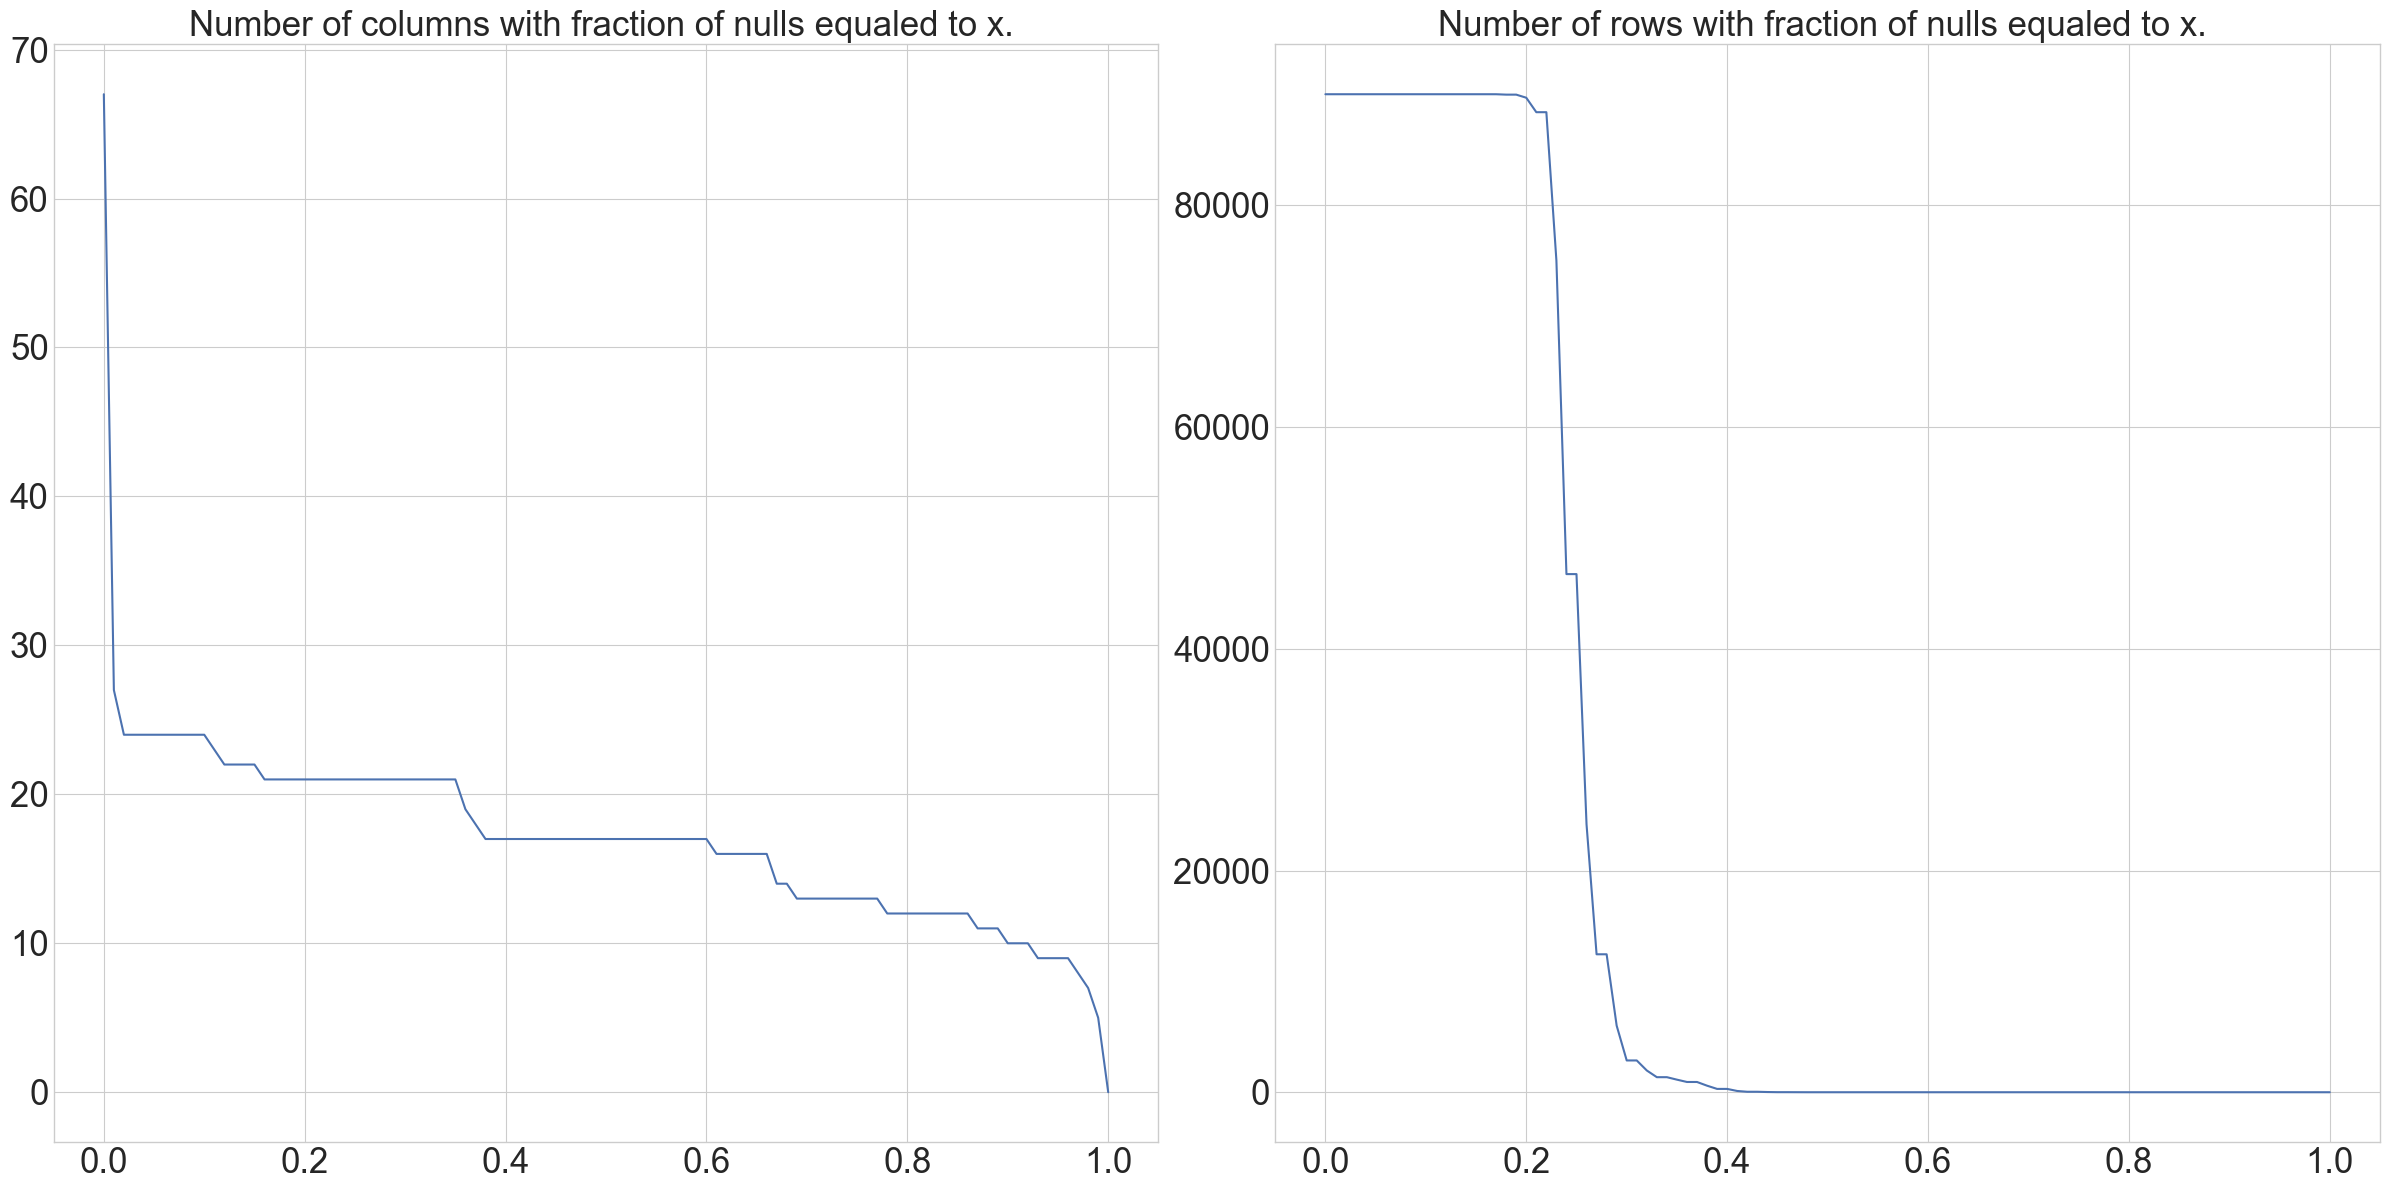

In [18]:
# Transposing data to change axises.
null_frac_cols = train.isnull().mean()
null_frac_rows = train.T.isnull().mean()
nrows_per_null_frac = np.zeros(101)
ncols_per_null_frac = np.zeros(101)
fractions = np.linspace(0, 100, num=101, endpoint=True)

# From 0 to 100 in order to avoid trailing digits in the floats. 
for i, value in enumerate(fractions):
    value /= 100 
    nrows_per_null_frac[i] = null_frac_rows[null_frac_rows >= value].index.shape[0]
    ncols_per_null_frac[i] = null_frac_cols[null_frac_cols >= value].index.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(24, 12))
data = [['columns', ncols_per_null_frac], ['rows', nrows_per_null_frac]]

for i, (ax, (lbl, y)) in enumerate(zip(axes, data)):
    sns.lineplot(y=y, x=fractions / 100, ax=axes[i]);
    ax.tick_params(axis='both', labelsize=25)
    ax.set_title(f"Number of {lbl} with fraction of nulls equaled to x. ", fontsize=25)

plt.tight_layout()

**Conclusions**:
1. The columns with nulls are stable. We can divide features into groups with large missingness and none missingness. These groups will be approximately of the same size. 
2. There is a sharp decrease on the rows plot. The cause is the missingness nature of columns (p. 1).
3. Some rows are completely missing indicating some erroneous samples. 

#### Correlations analysis

In [22]:
lgst_clas = find_adv_missing_per_col(train, ANALYSIS_RESULTS_DIR, model_name='logistic')
lgbm_clas = find_adv_missing_per_col(train, ANALYSIS_RESULTS_DIR, model_name='lgbm')
miss_corrs = find_missing_corrs_per_col(train.drop(columns=cfg.index_col), ANALYSIS_RESULTS_DIR)

File already exists. Loading it...
File already exists. Loading it...
File already exists. Loading it...


#### Examining

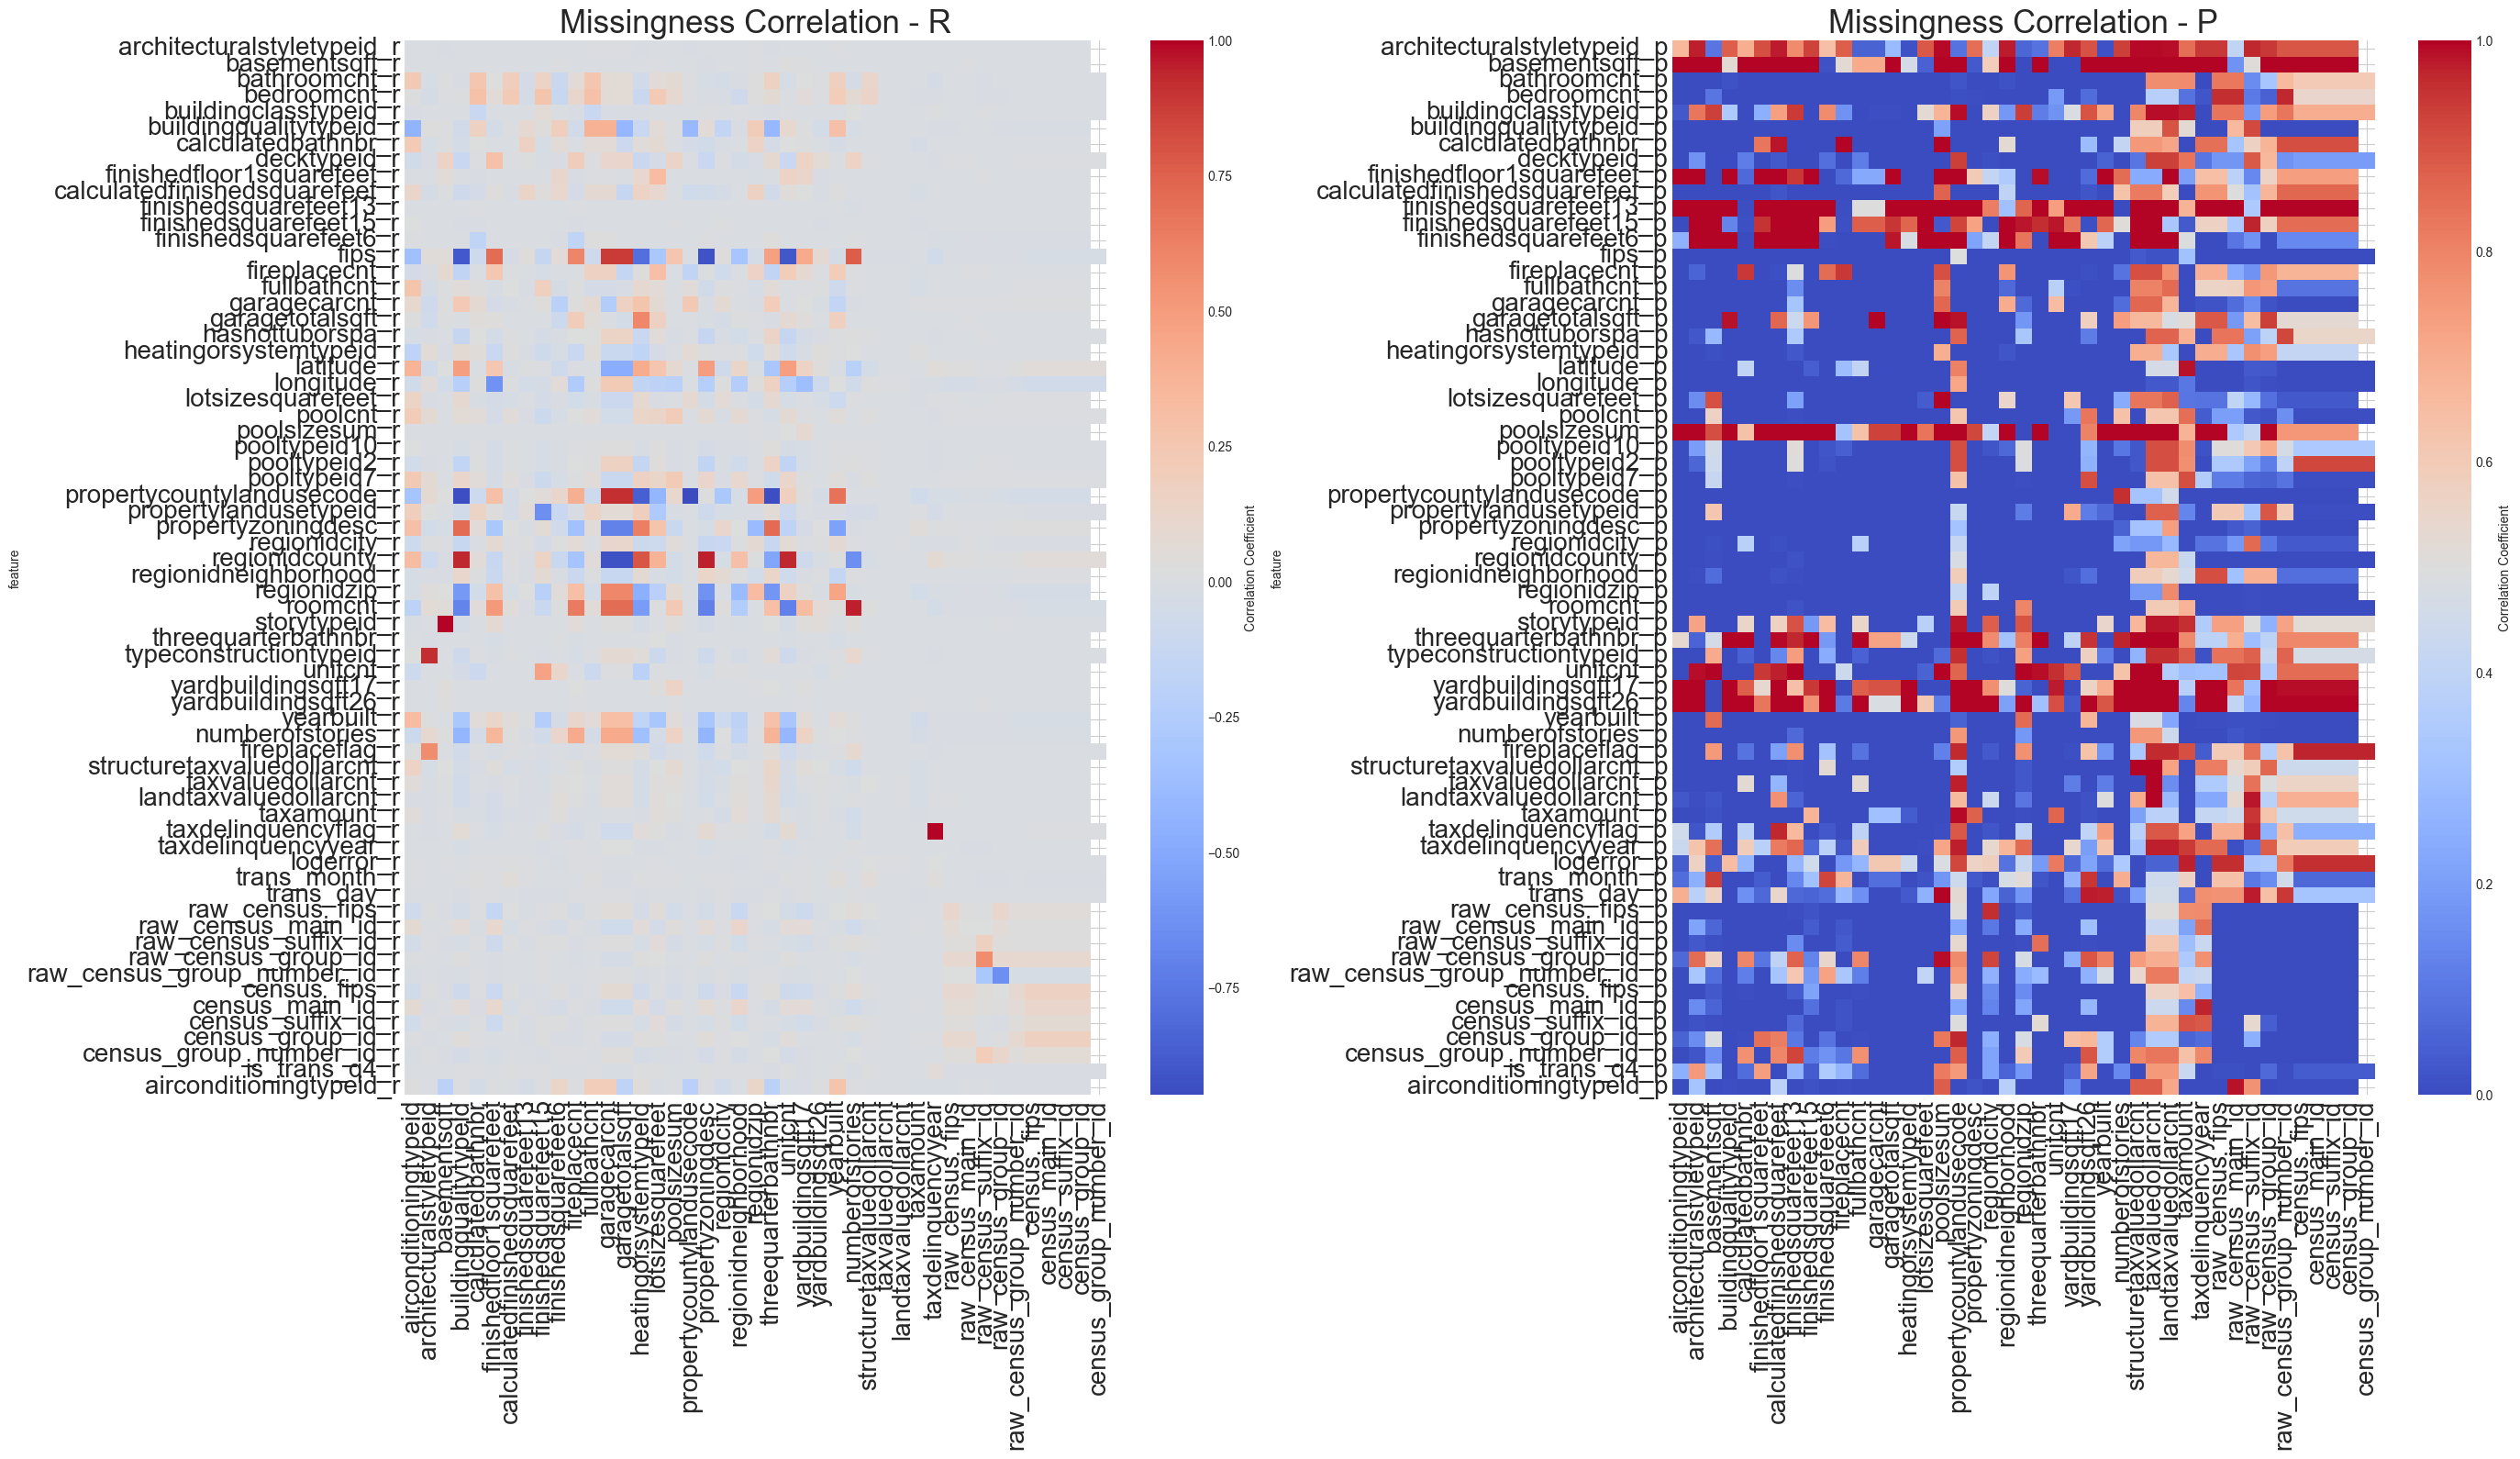

In [25]:
plot_miss_corrs(miss_corrs)

In [26]:
def select_important_missing_cols(df, lgst_clas=None, lgbm_clas=None, miss_corrs=None):
    missing_cols = df.columns[df.isna().any(axis=0)]
    unimportant_cols = set()

    if lgst_clas is not None:
        unimportant_cols |= (set(lgst_clas[lgst_clas['mean'] < 0.6].index.to_list()))
    
    if lgbm_clas is not None:
        unimportant_cols |= (set(lgbm_clas[lgbm_clas['mean'] < 0.7].index.to_list()))
    
    if miss_corrs is not None:
        unimportant_cols |= set(find_unimportant_cols_from_miss_corrs(miss_corrs))
        
    return df[find_unshared_cols(missing_cols, unimportant_cols)]

def find_unimportant_cols_from_miss_corrs(miss_corrs: pd.DataFrame):
    significant_r = 0.15
    correlated_cols_pct = 10
    significant_pvalue = cfg.stat_significant_magnitude / miss_corrs.shape[1]
    significant_count = miss_corrs.shape[1] * correlated_cols_pct / 100

    corrs_r, corrs_p = split_rp_from_miss_corr_df(miss_corrs)
    corrs_r = corrs_r.sort_index().abs()
    corrs_p = corrs_p.sort_index().abs()

    def is_important(col):
        r_and_p = (corrs_p[col] <= significant_pvalue).values & (corrs_r[col] >= significant_r).values
        return r_and_p.sum() >= significant_count

    imp_cols = [c for c in miss_corrs.columns if is_important(c)]
    return find_unshared_cols(imp_cols, miss_corrs.columns)
    

(19,)


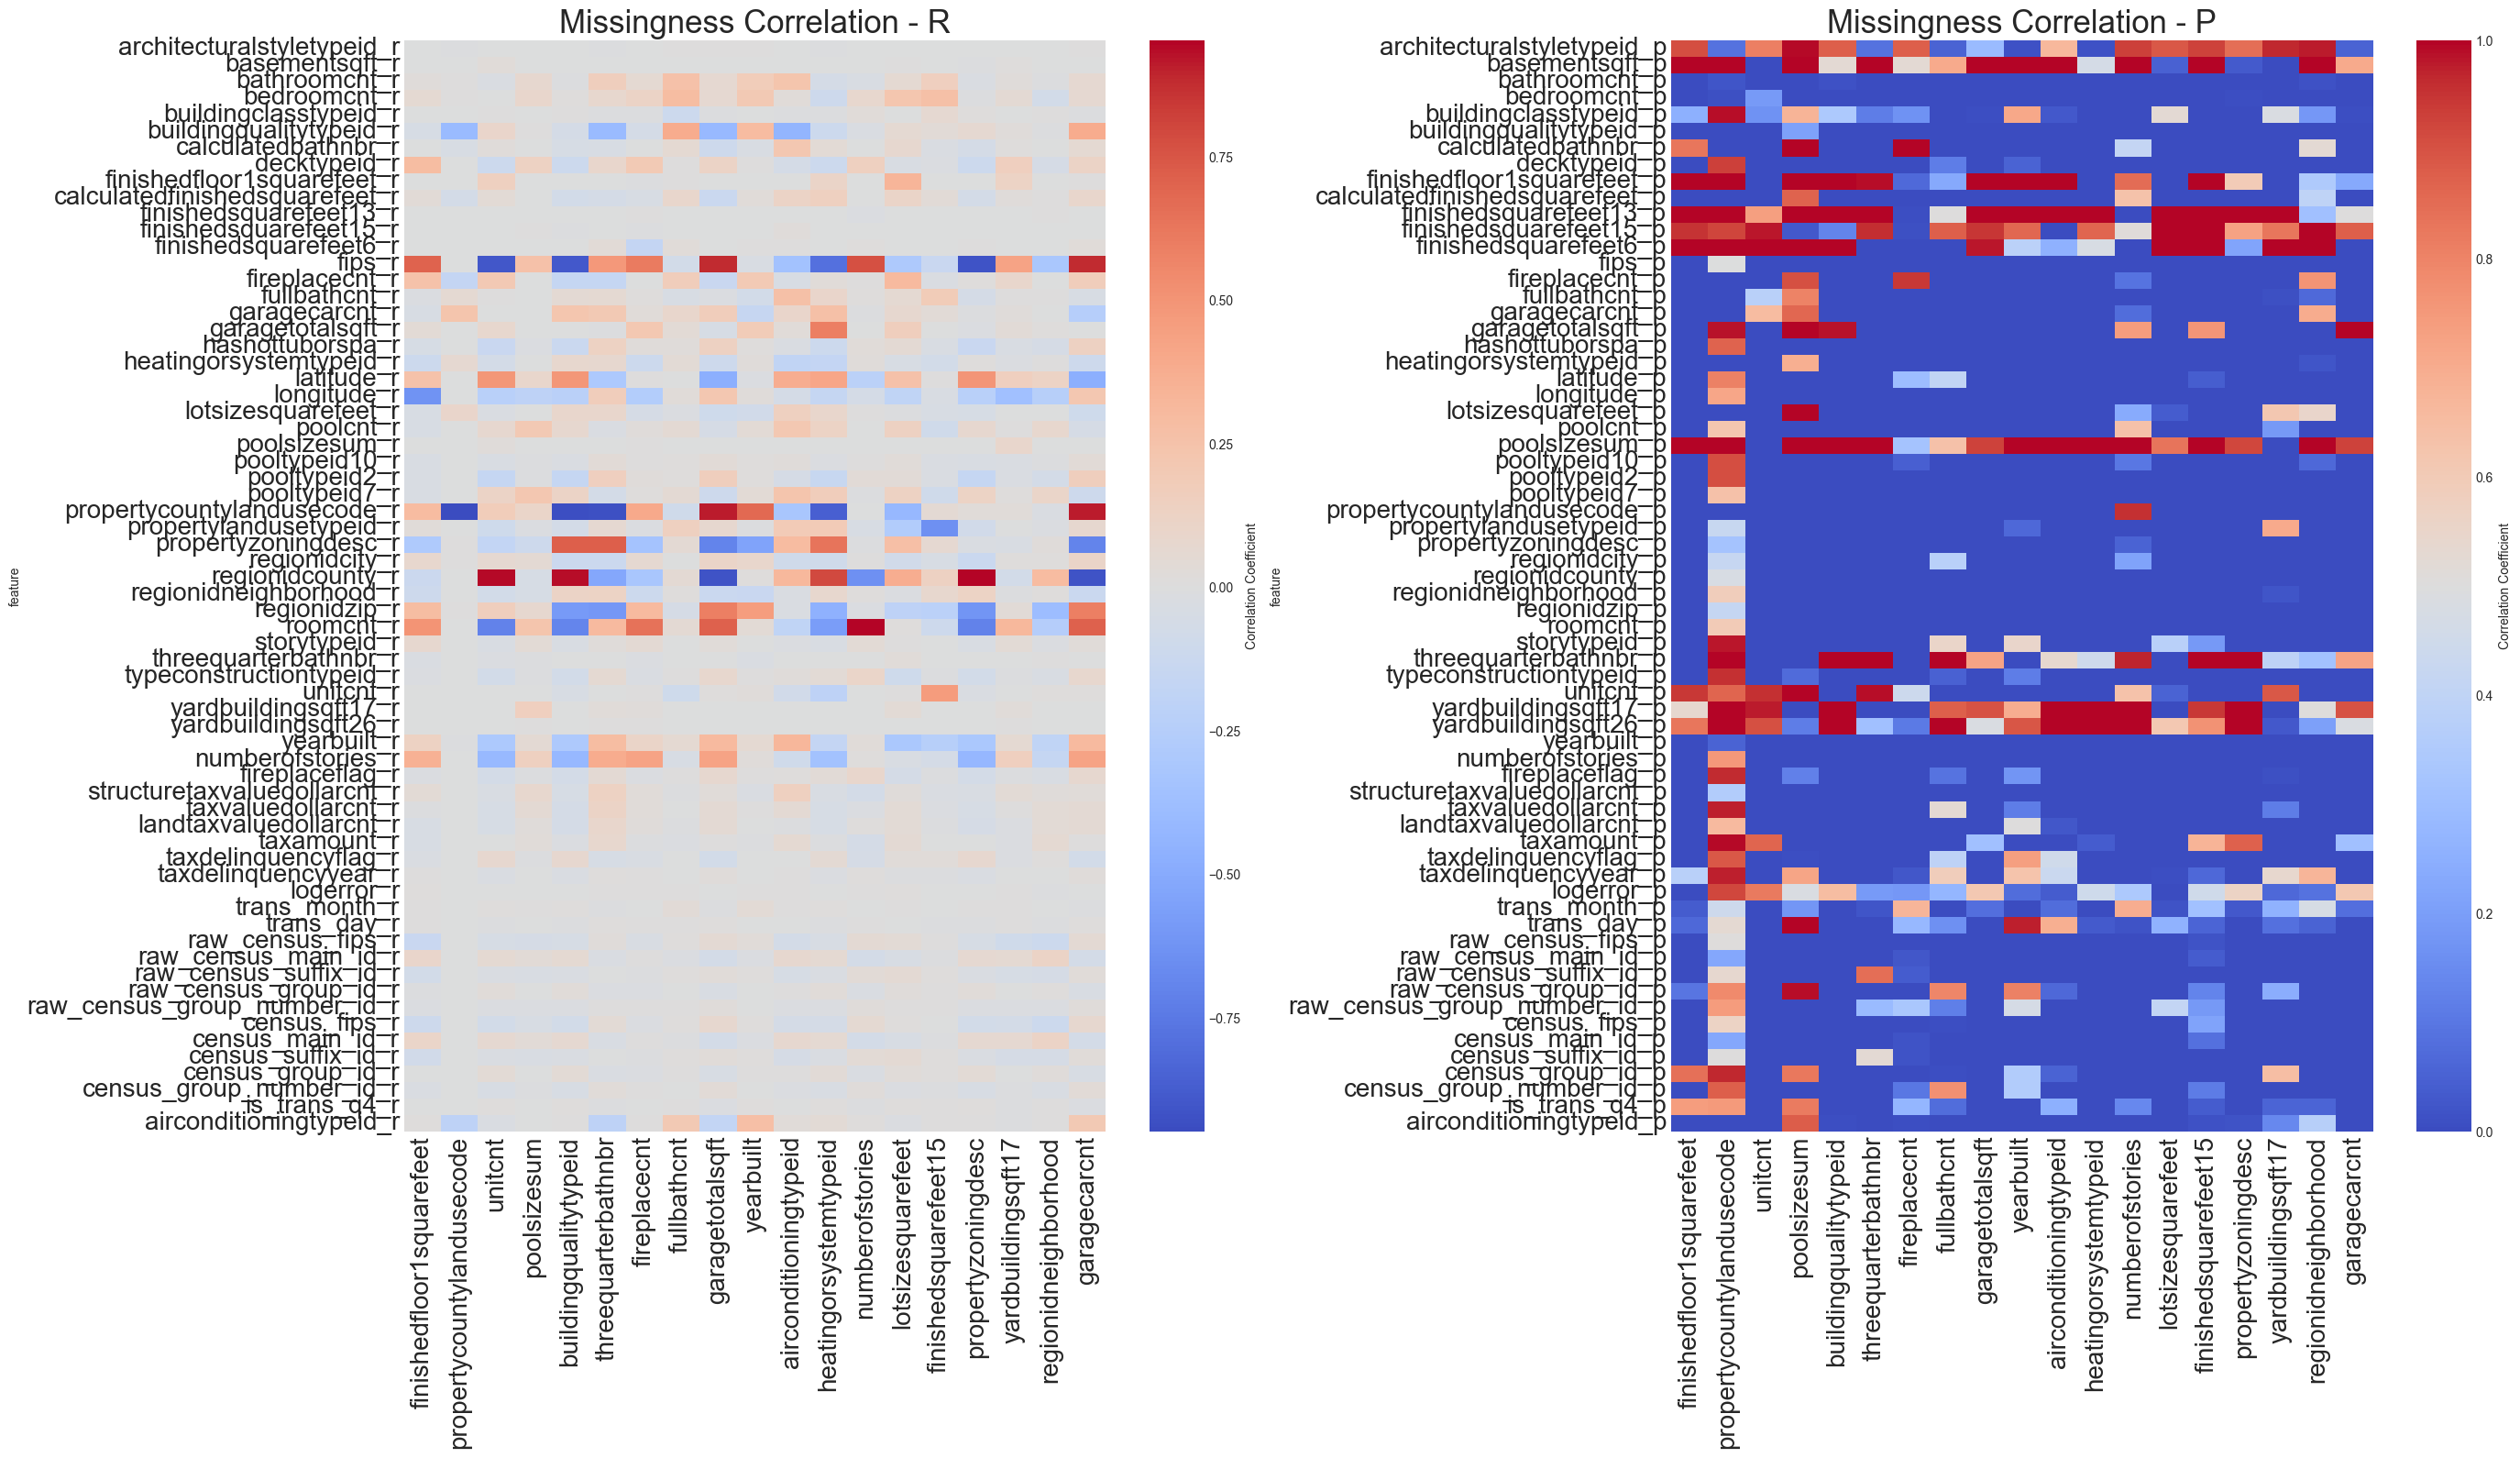

In [27]:
miss_selected_train = select_important_missing_cols(train, lgst_clas, lgbm_clas, miss_corrs)
miss_selected_cols = miss_selected_train.columns
print(miss_selected_train.columns.shape)
plot_miss_corrs(miss_corrs=miss_corrs[miss_selected_cols])

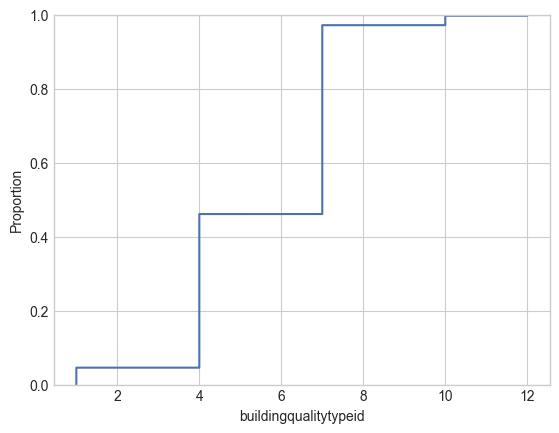

In [28]:
sns.ecdfplot(train['buildingqualitytypeid'].abs().sort_values());

In [29]:
small = null_frac_cols[null_frac_cols.between(0, 0.05, inclusive='right')].index
moderate = null_frac_cols[null_frac_cols.between(0.05, 0.3, inclusive='right')].index
large = null_frac_cols[null_frac_cols.between(0.3, 0.9, inclusive='right')].index
extreme = null_frac_cols[null_frac_cols.gt(0.9)].index

group_cols_by_missing_ratio = [small, moderate, large, extreme]

In [30]:
# correlation with missing ratio
for gr in group_cols_by_missing_ratio:
    print(len(find_shared_cols(gr, miss_selected_cols)) / len(gr) * 100)

15.789473684210526
33.33333333333333
100.0
40.0


### Duplicates

In [ ]:
res = []

for fname in os.listdir(RAW_DATA_DIR):
    if fname.split('.')[-1] == 'parquet':
        path = RAW_DATA_DIR + fname
        try:
            df = pd.read_parquet(path, columns=['parcelid']) 
            res.append([fname, df['parcelid'].duplicated().sum()])
        except:
            continue

res

NameError: name 'DATA_DIR' is not defined

#### Duplicates in train 2016 and 2017

In [ ]:
df = pd.read_csv(r'd:\Coding\VSCFiles\IndependentProjects\Kaggle\zillow-2016\data\train_2017.csv')
df2 = pd.read_csv(r'd:\Coding\VSCFiles\IndependentProjects\Kaggle\zillow-2016\data\train_2016_v2.csv')

c = 'parcelid'
duplicated = find_shared_cols(df[c], df2[c])
dupl1 = df[df[c].isin(duplicated)].sort_values(c)
dupl2 = df2[df2[c].isin(duplicated)].sort_values(c)

In [ ]:
dupl1.head(), dupl2.head()

(       parcelid  logerror transactiondate
 18017  10711910 -0.041238      2017-03-17
 46168  10713956  0.008037      2017-06-14
 39962  10719631 -0.036742      2017-05-25
 36951  10720221 -0.055345      2017-05-17
 74513  10720461 -0.076361      2017-09-07,
        parcelid  logerror transactiondate
 71190  10711910    0.2897      2016-08-30
 55752  10713956   -0.0263      2016-07-14
 34026  10719631    0.0257      2016-05-11
 86494  10720221    0.2484      2016-10-28
 54724  10720461   -0.0131      2016-07-12)

Completely different transaction!

#### Inner target duplicates

In [ ]:
df[df[c] == 10722858]

parcelid  logerror transactiondate
14033  10722858  0.095171      2017-03-02
14034  10722858 -0.172843      2017-07-28

In [ ]:
dupl_2017 = df[df[c].duplicated()].sort_values(c)
dupl_2017

parcelid  logerror transactiondate
14034   10722858 -0.172843      2017-07-28
13914   10732347 -0.221145      2017-07-25
2905    10739478 -0.262967      2017-03-31
28611   10744507 -0.050062      2017-08-31
3540    10753427 -0.145781      2017-03-17
37328   10753829 -0.147141      2017-08-18
30045   10777937 -0.062730      2017-09-06
19107   10779619 -0.286966      2017-08-28
17099   10792511 -0.160767      2017-07-21
37107   10808647 -0.286743      2017-07-27
21345   10811539 -0.021841      2017-08-30
24864   10833654 -0.187010      2017-09-05
62239   10852812  2.237069      2017-08-31
44963   10857130  0.290908      2017-08-25
44962   10857130  0.053244      2017-06-30
12420   10858360 -0.210259      2017-06-16
29064   10871677 -0.110893      2017-06-01
41810   10879060 -0.167847      2017-08-23
17405   10903921 -0.054919      2017-08-29
13665   10929090  0.175347      2017-07-11
27452   10946379  0.008608      2017-08-11
54496   10956664  0.016120      2017-08-31
8301    10976131  0.062132      2017-05-31
33837   10979425 -0.241779      2017-09-18
64944   10984080  0.860596      2017-09-12
9833    10984661 -0.260699      2017-07-31
18562   11061050 -0.128386      2017-09-08
40443   11065727 -0.207197      2017-08-31
17549   11083106 -0.232313      2017-06-29
35357   11106339 -0.140602      2017-09-08
16443   11141309 -0.066425      2017-06-20
9471    11187927 -0.382067      2017-06-14
16013   11289757 -0.195953      2017-08-30
1248    11289917 -0.362001      2017-06-23
10803   11312124 -0.216892      2017-06-01
10790   11367981 -0.044478      2017-05-22
3273    11389003 -0.325393      2017-06-01
7764    11391577 -0.269754      2017-06-02
4458    11391972 -0.026896      2017-07-20
117     11393337  0.086137      2017-06-08
12871   11401519 -0.225614      2017-04-14
9593    11420117  0.019240      2017-03-09
3905    11429175 -0.064447      2017-08-23
19059   11433174 -0.035228      2017-07-25
2681    11446756 -0.163064      2017-08-23
9597    11451345 -0.236683      2017-08-25
5064    11460552 -0.027589      2017-08-29
17535   11460921 -0.382853      2017-09-08
39209   11491470  0.151207      2017-08-25
7062    11496770 -0.041077      2017-04-13
4418    11499166  0.006474      2017-01-31
30343   11499751  0.180302      2017-08-17
6235    11501340  0.028292      2017-04-25
28585   11501341  0.067573      2017-07-24
54971   11501342  0.501279      2017-09-13
7085    11552513 -0.226048      2017-05-17
14028   11577176 -0.186148      2017-07-13
28596   11594130 -0.103051      2017-09-19
30411   11603473 -0.053398      2017-07-05
6419    11605789  0.325387      2017-04-03
12223   11627049 -0.066764      2017-04-28
1734    11637029 -0.093399      2017-07-28
8681    11658743 -0.154881      2017-04-04
11416   11694397  0.010736      2017-08-25
3908    11696784 -0.124790      2017-06-16
1772    11705026 -0.146056      2017-06-30
11055   11711539 -0.155028      2017-04-27
32732   11717962 -0.279802      2017-08-31
1018    11721753  0.017785      2017-07-21
18849   11733550 -0.115499      2017-08-18
22576   11739891 -0.285895      2017-04-06
4527    11743374 -0.275799      2017-07-14
17866   11797465 -0.320227      2017-08-08
48339   11828977 -0.029649      2017-09-01
20953   11830465  0.388671      2017-08-17
19419   11917650  0.194401      2017-08-11
4254    11921077 -0.330879      2017-07-18
27707   11923149 -0.043041      2017-07-18
53369   11938901 -0.503560      2017-09-01
10543   11957553 -0.116322      2017-09-19
31224   11958628 -0.242346      2017-08-29
16177   11961462 -0.245534      2017-08-23
3429    11967869 -0.005566      2017-06-29
15738   11969146 -0.276996      2017-08-22
43842   11991059  2.508444      2017-06-13
43841   11991059  2.670239      2017-06-09
27062   11999890  0.393642      2017-06-08
56243   12002715 -0.049091      2017-09-05
26041   12027770  0.032778      2017-09-08
5444    12035176 -0.114435      2017-05-24
12671   12035592 -0.236762      2017-08-22
21510   12048224 -0.096497      2017-06-15
8879    1

In [ ]:
df[c].value_counts(), df2[c].value_counts()

(parcelid
 11991059     3
 10857130     3
 12612211     3
 10984661     2
 10946379     2
 13893511     2
 13880422     2
 12814323     2
 14088988     2
 14604480     2
 10808647     2
 12505219     2
 10811539     2
 14637110     2
 12749741     2
 11083106     2
 14532131     2
 17165634     2
 11705026     2
 13066981     2
 11637029     2
 12385712     2
 11797465     2
 10753829     2
 12048224     2
 14269464     2
 11694397     2
 11460921     2
 14626467     2
 14718350     2
 14606311     2
 10792511     2
 11627049     2
 12892594     2
 12118682     2
 17165666     2
 12641353     2
 12443331     2
 11999890     2
 12693966     2
 12955531     2
 12347492     2
 10903921     2
 11391577     2
 17243116     2
 11958628     2
 12002715     2
 12068159     2
 10976131     2
 11446756     2
 14655760     2
 12224279     2
 12613390     2
 11957553     2
 11733550     2
 11501341     2
 11594130     2
 14634203     2
 10744507     2
 11433174     2
 10779619     2
 11923149     